In [3]:
# Importing libraries
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import boxcox
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import shap
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [1]:
# Set up figures' format
%config InlineBackend.figure_format = 'svg'

In [4]:
# Reading input datasets
nyc,preds = pd.read_csv('nyc_16.csv'), pd.read_csv('nyc_16_preds.csv')

In [2]:
# CatBoost set-up
print(catboost.__version__)
!python --version

1.2.3
Python 3.9.18


In [5]:
# ID/income columns separation
income = nyc['income']
id = preds['id']

In [6]:
nyc.head(5)

,income,surface_volume_disorderliness_mean,surface_roughness_disorderliness_mean,ndbi_built_contrast_mean,tcap_wetness_mean,tcap_greenness_std,surface_structure_mean,nir_band_mean,swir2_band_std,colour_brightness_coherence_mean,ndwi_wetness_contrast_mean,ndwi_wetness_coherence_std,tcap_greenness_contrast_mean,tcap_wetness_coherence_mean,tcap_wetness_disorderliness_mean
0,8493,0.017130,0.814135,217.872348,-665.530652,627.449148,6.415450,2177.999992,321.131683,0.710326,266.483045,0.025364,7925.116342,0.252157,0.229983
1,8661,0.001337,0.173303,112.098695,-531.174148,596.292631,6.424380,2450.187944,226.175824,0.665381,239.711962,0.046787,11950.392780,0.146667,0.108934
2,8937,0.060357,1.023679,178.039798,-822.287856,795.344584,6.778668,2360.712700,809.007484,0.766321,185.074525,0.026551,6106.666968,0.308033,0.427918
3,9318,0.002171,0.891328,156.429253,-847.810048,445.174355,10.820765,2138.630441,536.762280,0.637663,181.524375,0.027951,3797.473041,0.380356,0.543457
4,9463,0.044954,0.824878,229.363213,-947.867779,714.081034,9.267255,2154.809000,679.340071,0.670963,181.633017,0.031354,4033.179572,0.304398,0.515951


In [7]:
preds.head(5)

,id,surface_volume_disorderliness_mean,surface_roughness_disorderliness_mean,ndbi_built_contrast_mean,tcap_wetness_mean,tcap_greenness_std,surface_structure_mean,nir_band_mean,swir2_band_std,colour_brightness_coherence_mean,ndwi_wetness_contrast_mean,ndwi_wetness_coherence_std,tcap_greenness_contrast_mean,tcap_wetness_coherence_mean,tcap_wetness_disorderliness_mean,x_coord,y_coord
0,390,0.017130,0.814135,217.872348,-665.530652,627.449148,6.415450,2177.999992,321.131683,0.710326,266.483045,0.025364,7925.116342,0.252157,0.229983,-8.229359e+06,4.988148e+06
1,6310,0.001337,0.173303,112.098695,-531.174148,596.292631,6.424380,2450.187944,226.175824,0.665381,239.711962,0.046787,11950.392780,0.146667,0.108934,-8.255796e+06,4.958258e+06
2,2936,0.060357,1.023679,178.039798,-822.287856,795.344584,6.778668,2360.712700,809.007484,0.766321,185.074525,0.026551,6106.666968,0.308033,0.427918,-8.227063e+06,4.964208e+06
3,305,0.002171,0.891328,156.429253,-847.810048,445.174355,10.820765,2138.630441,536.762280,0.637663,181.524375,0.027951,3797.473041,0.380356,0.543457,-8.225909e+06,4.986129e+06
4,131,0.044954,0.824878,229.363213,-947.867779,714.081034,9.267255,2154.809000,679.340071,0.670963,181.633017,0.031354,4033.179572,0.304398,0.515951,-8.228484e+06,4.985544e+06


In [8]:
# Normalising predictors
first_col = nyc.iloc[:, 0]
remaining_cols = nyc.iloc[:, 1:]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the remaining columns of X and transform them
remaining_scaled = pd.DataFrame(scaler.fit_transform(remaining_cols), columns=remaining_cols.columns)

# Reset indices to ensure they align for concatenation
first_col = first_col.reset_index(drop=True)
remaining_scaled = remaining_scaled.reset_index(drop=True)

# Concatenate the first column back with the scaled remaining columns
nyc = pd.concat([first_col, remaining_scaled], axis=1)

# Print the final DataFrame with the unscaled first column and scaled remaining columns
print(nyc)


      income  surface_volume_disorderliness_mean  \
0       8493                            0.006267   
1       8661                            0.000489   
2       8937                            0.022082   
3       9318                            0.000794   
4       9463                            0.016447   
...      ...                                 ...   
5785  250001                            0.013916   
5786  250001                            0.034909   
5787  250001                            0.039105   
5788  250001                            0.178122   
5789  250001                            0.009184   

      surface_roughness_disorderliness_mean  ndbi_built_contrast_mean  \
0                                  0.158896                  0.408502   
1                                  0.033812                  0.149230   
2                                  0.199797                  0.310865   
3                                  0.173963                  0.257893   
4         

In [9]:
# Normalising predictors
first_col = preds.iloc[:, 0]
remaining_cols = preds.iloc[:, 1:]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the remaining columns of X and transform them
remaining_scaled = pd.DataFrame(scaler.fit_transform(remaining_cols), columns=remaining_cols.columns)

# Reset indices to ensure they align for concatenation
first_col = first_col.reset_index(drop=True)
remaining_scaled = remaining_scaled.reset_index(drop=True)

# Concatenate the first column back with the scaled remaining columns
preds = pd.concat([first_col, remaining_scaled], axis=1)

# Print the final DataFrame with the unscaled first column and scaled remaining columns
print(preds)


        id  surface_volume_disorderliness_mean  \
0      390                            0.006267   
1     6310                            0.000489   
2     2936                            0.022082   
3      305                            0.000794   
4      131                            0.016447   
...    ...                                 ...   
5785  3899                            0.013916   
5786  3918                            0.034909   
5787  3919                            0.039105   
5788  4292                            0.178122   
5789  6332                            0.009184   

      surface_roughness_disorderliness_mean  ndbi_built_contrast_mean  \
0                                  0.158896                  0.408502   
1                                  0.033812                  0.149230   
2                                  0.199797                  0.310865   
3                                  0.173963                  0.257893   
4                                 

In [10]:
column_names = preds.columns.tolist()
column_names


['id',
 'surface_volume_disorderliness_mean',
 'surface_roughness_disorderliness_mean',
 'ndbi_built_contrast_mean',
 'tcap_wetness_mean',
 'tcap_greenness_std',
 'surface_structure_mean',
 'nir_band_mean',
 'swir2_band_std',
 'colour_brightness_coherence_mean',
 'ndwi_wetness_contrast_mean',
 'ndwi_wetness_coherence_std',
 'tcap_greenness_contrast_mean',
 'tcap_wetness_coherence_mean',
 'tcap_wetness_disorderliness_mean',
 'x_coord',
 'y_coord']

In [11]:
income = nyc['income']
id = preds['id']

In [12]:
# Creating y/X dataframes
y = nyc.income
X = preds.drop('id', axis=1)

In [13]:
# Dropping geographic coordinates
X = X.drop('x_coord', axis=1)
X = X.drop('y_coord', axis=1)

In [14]:
X

,surface_volume_disorderliness_mean,surface_roughness_disorderliness_mean,ndbi_built_contrast_mean,tcap_wetness_mean,tcap_greenness_std,surface_structure_mean,nir_band_mean,swir2_band_std,colour_brightness_coherence_mean,ndwi_wetness_contrast_mean,ndwi_wetness_coherence_std,tcap_greenness_contrast_mean,tcap_wetness_coherence_mean,tcap_wetness_disorderliness_mean
0,0.006267,0.158896,0.408502,0.539548,0.437268,0.019910,0.478176,0.179310,0.555111,0.421591,0.140127,0.457379,0.233782,0.060141
1,0.000489,0.033812,0.149230,0.638601,0.415555,0.019948,0.576194,0.126290,0.466009,0.369334,0.258484,0.694239,0.125701,0.028486
2,0.022082,0.199797,0.310865,0.423982,0.554273,0.021465,0.543973,0.451725,0.666122,0.262683,0.146684,0.350375,0.291032,0.111900
3,0.000794,0.173963,0.257893,0.405166,0.310241,0.038767,0.463999,0.299712,0.411057,0.255753,0.154420,0.214495,0.365132,0.142114
4,0.016447,0.160993,0.436669,0.331400,0.497641,0.032117,0.469825,0.379323,0.477074,0.255965,0.173220,0.228364,0.287308,0.134921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5785,0.013916,0.116882,0.418343,0.844895,0.715219,0.017384,0.602109,0.204515,0.708393,0.323178,0.540064,0.270879,0.631447,0.698539
5786,0.034909,0.236760,0.404727,0.637000,0.263788,0.016079,0.312436,0.153726,0.549082,0.355889,0.723894,0.292057,0.339967,0.300666
5787,0.039105,0.279787,0.469610,0.655760,0.210605,0.015306,0.253289,0.153109,0.462156,0.359348,0.244453,0.307393,0.381655,0.200594
5788,0.178122,0.576251,0.782504,0.586392,0.389576,0.049969,0.366016,0.281109,0.771263,0.350988,0.320681,0.365179,0.428717,0.378213


In [15]:
dataset_dir = './inc_nyc'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# We will be able to work with files with/without header and
# with different separators.

nyc.to_csv(
    os.path.join(dataset_dir, 'train.csv'),
    index=False, sep=',', header=True
)
preds.to_csv(
    os.path.join(dataset_dir, 'preds.csv'),
    index=False, sep=',', header=True
)

In [16]:
pool1 = Pool(data=X, label=y)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 

Dataset shape
dataset 1:(5790, 14)


Column names
dataset 1:
['surface_volume_disorderliness_mean', 'surface_roughness_disorderliness_mean', 'ndbi_built_contrast_mean', 'tcap_wetness_mean', 'tcap_greenness_std', 'surface_structure_mean', 'nir_band_mean', 'swir2_band_std', 'colour_brightness_coherence_mean', 'ndwi_wetness_contrast_mean', 'ndwi_wetness_coherence_std', 'tcap_greenness_contrast_mean', 'tcap_wetness_coherence_mean', 'tcap_wetness_disorderliness_mean']


TBB Warning: The number of workers is currently limited to 5. The request for 39 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



In [17]:
# Train/validation split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

In [18]:
# Optimizing hyperparameters
train_pool = Pool(data=X_train, label=y_train)
validation_pool = Pool(data=X_validation, label=y_validation)

# Define the function to optimize
def catboost_cv(learning_rate, iterations, depth, l2_leaf_reg):
    # Convert continuous parameters to integer where necessary
    iterations = int(iterations)
    depth = int(depth)
    
    # Define and train the model
    model = CatBoostRegressor(
        learning_rate=learning_rate,
        iterations=iterations,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        loss_function='RMSE',
        eval_metric='R2',
        random_seed=42,
        logging_level='Silent'
    )
    
    model.fit(train_pool, eval_set=validation_pool, use_best_model=True)
    
    # Calculate R-squared values
    train_r2 = model.score(train_pool)
    test_r2 = model.score(validation_pool)
    
    # Ensure that train R-squared does not exceed test R-squared by more than 0.1
    if train_r2 - test_r2 > 0.1:
        return 0  # Penalize the function if the condition is not met
    
    return test_r2

# Define the initial bounds for hyperparameters
param_bounds = {
    'learning_rate': (0.01, 0.1), 
    'iterations': (1000, 10000), 
    'depth': (2, 5), 
    'l2_leaf_reg': (2, 100)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=catboost_cv,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

# Perform optimization
optimizer.maximize(
    init_points=20,  # Number of initial random points
    n_iter=50       # Number of optimization iterations
)

# Extract the best parameters
best_params = optimizer.max['params']
best_params['iterations'] = int(best_params['iterations'])
best_params['depth'] = int(best_params['depth'])

print("Best hyperparameters found were:")
print(best_params)


|   iter    |  target   |   depth   | iterat... | l2_lea... | learni... |
-------------------------------------------------------------------------
| 1         | 0.0       | 3.124     | 9.556e+03 | 73.74     | 0.06388   |
| 2         | 0.0       | 2.468     | 2.404e+03 | 7.692     | 0.08796   |
| 3         | 0.0       | 3.803     | 7.373e+03 | 4.017     | 0.09729   |
| 4         | 0.0       | 4.497     | 2.911e+03 | 19.82     | 0.02651   |
| 5         | 0.0       | 2.913     | 5.723e+03 | 44.33     | 0.03621   |
| 6         | 0.0       | 3.836     | 2.255e+03 | 30.63     | 0.04297   |
| 7         | 0.0       | 3.368     | 8.067e+03 | 21.57     | 0.05628   |
| 8         | 0.4499    | 3.777     | 1.418e+03 | 61.54     | 0.02535   |
| 9         | 0.0       | 2.195     | 9.54e+03  | 96.63     | 0.08276   |
| 10        | 0.0       | 2.914     | 1.879e+03 | 69.05     | 0.04961   |
| 11        | 0.0       | 2.366     | 5.457e+03 | 5.37      | 0.09184   |
| 12        | 0.0       | 2.776     | 

In [20]:
# Fitting CatBoost model
tuned_model = CatBoostRegressor(
    random_seed=63,
    iterations=1206,
    task_type="CPU",
    learning_rate=0.022769307539655913,
    l2_leaf_reg = 69,
    depth = 4,
    loss_function='MAE'
)
tuned_model.fit(
    X_train, y_train,
    verbose=False,
    eval_set=(X_validation, y_validation),
    early_stopping_rounds=50,
    plot=True
)
results = tuned_model.get_evals_result()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

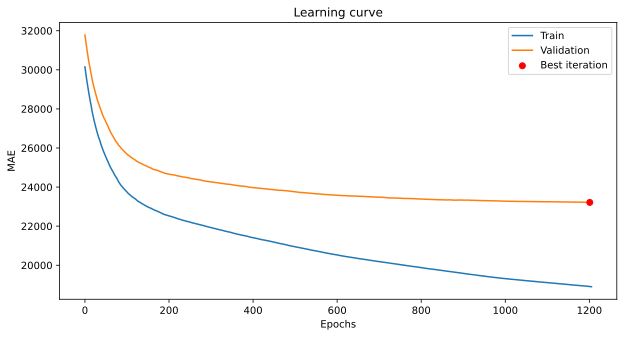

In [21]:
# Plotting model's iterations
epochs = np.arange(len(results['learn']['MAE']))

# Retrieve the best iteration from the model
best_iteration = tuned_model.get_best_iteration()

plt.figure(figsize=(10, 5))
plt.plot(epochs, results['learn']['MAE'], label='Train')
plt.plot(epochs, results['validation']['MAE'], label='Validation')

# Mark the best iteration on the plot
if best_iteration is not None:
    plt.scatter(best_iteration, results['validation']['MAE'][best_iteration], color='red', zorder=5, label='Best iteration')

plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Learning curve')
plt.legend()
plt.show()


In [22]:
pool1 = Pool(data=X, label=y)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 

Dataset shape
dataset 1:(5790, 14)


Column names
dataset 1:
['surface_volume_disorderliness_mean', 'surface_roughness_disorderliness_mean', 'ndbi_built_contrast_mean', 'tcap_wetness_mean', 'tcap_greenness_std', 'surface_structure_mean', 'nir_band_mean', 'swir2_band_std', 'colour_brightness_coherence_mean', 'ndwi_wetness_contrast_mean', 'ndwi_wetness_coherence_std', 'tcap_greenness_contrast_mean', 'tcap_wetness_coherence_mean', 'tcap_wetness_disorderliness_mean']


In [23]:
# Cross-validation-based quality metrics
# Define the model with IncToDec overfitting detection
model = CatBoostRegressor(
    random_seed=63,
    iterations=1206,
    task_type="CPU",
    learning_rate=0.022769307539655913,
    l2_leaf_reg=69,
    depth=4,
    loss_function='MAE'
)

# Setup robust cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

# Prepare lists to store results
train_scores = []
test_scores = []
train_maes = []
test_maes = []
train_rmses = []
test_rmses = []

# Loop over each fold
for train_idx, test_idx in rkf.split(X):
    train_pool = Pool(X.iloc[train_idx], y.iloc[train_idx])
    test_pool = Pool(X.iloc[test_idx], y.iloc[test_idx])
    
    # Fit model with early stopping
    model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100, verbose=False)
    
    # Predict on train and test sets
    train_preds = model.predict(train_pool)
    test_preds = model.predict(test_pool)
    
    # Calculate R-squared
    train_scores.append(model.score(train_pool))
    test_scores.append(model.score(test_pool))
    
    # Calculate MAE
    train_maes.append(mean_absolute_error(y.iloc[train_idx], train_preds))
    test_maes.append(mean_absolute_error(y.iloc[test_idx], test_preds))
    
    # Calculate RMSE
    train_rmses.append(np.sqrt(mean_squared_error(y.iloc[train_idx], train_preds)))
    test_rmses.append(np.sqrt(mean_squared_error(y.iloc[test_idx], test_preds)))

# Calculate the average and standard deviation of R-squared across all train and test folds
mean_train_r2 = np.mean(train_scores)
std_train_r2 = np.std(train_scores)
mean_test_r2 = np.mean(test_scores)
std_test_r2 = np.std(test_scores)

# Calculate the average and standard deviation of MAE across all train and test folds
mean_train_mae = np.mean(train_maes)
std_train_mae = np.std(train_maes)
mean_test_mae = np.mean(test_maes)
std_test_mae = np.std(test_maes)

# Calculate the average and standard deviation of RMSE across all train and test folds
mean_train_rmse = np.mean(train_rmses)
std_train_rmse = np.std(train_rmses)
mean_test_rmse = np.mean(test_rmses)
std_test_rmse = np.std(test_rmses)

print("Average Train R-squared:", mean_train_r2)
print("Train R-squared Standard Deviation:", std_train_r2)
print("Average Test R-squared:", mean_test_r2)
print("Test R-squared Standard Deviation:", std_test_r2)
print("Average Train MAE:", mean_train_mae)
print("Train MAE Standard Deviation:", std_train_mae)
print("Average Test MAE:", mean_test_mae)
print("Test MAE Standard Deviation:", std_test_mae)
print("Average Train RMSE:", mean_train_rmse)
print("Train RMSE Standard Deviation:", std_train_rmse)
print("Average Test RMSE:", mean_test_rmse)
print("Test RMSE Standard Deviation:", std_test_rmse)


Average Train R-squared: 0.5564822180295372
Train R-squared Standard Deviation: 0.006554310577159032
Average Test R-squared: 0.451815663272999
Test R-squared Standard Deviation: 0.026280081028494287
Average Train MAE: 19165.136787946274
Train MAE Standard Deviation: 202.0249665493052
Average Test MAE: 22356.247723231096
Test MAE Standard Deviation: 733.5978406679756
Average Train RMSE: 27985.915972918792
Train RMSE Standard Deviation: 306.19144267416954
Average Test RMSE: 31077.74643436397
Test RMSE Standard Deviation: 1224.3876990237811
